In [2]:
# Cell 1: connect and inspect tables
import duckdb
import pandas as pd

DB_PATH = "../data/warehouse.duckdb"

# Open a persistent connection
con = duckdb.connect(database=DB_PATH, read_only=True)

# Improve scan speed on large parquet/duckdb sources
con.execute("PRAGMA threads=4;")

# See what tables/views exist
tables = con.sql("SHOW ALL TABLES;").df()
tables

,database,schema,name,column_names,column_types,temporary
0,warehouse,prod,sales,"[chargedate, meterid, chargedate_str, loc, res...","[DATE, BIGINT, VARCHAR, VARCHAR, VARCHAR, VARC...",False


In [3]:
# Cell 2: quick preview of prod.sales table
df_preview = con.sql("""
    SELECT *
    FROM prod.sales
    LIMIT 5;
""").df()

df_preview.head()


,chargedate,meterid,chargedate_str,loc,res,month,month_str,kwh,year,ghc,paymoney
0,2019-02-15,1,15-Feb-2019,Techiman [13],N-Resid [0],Feb-19,01-Feb-2019,14.2,2019,23.1705,140.0
1,2019-03-11,1,11-Mar-2019,Techiman [13],N-Resid [0],Mar-19,01-Mar-2019,57.4,2019,38.8886,40.0
2,2019-04-20,1,20-Apr-2019,Techiman [13],N-Resid [0],Apr-19,01-Apr-2019,57.4,2019,38.8886,20.0
3,2019-05-28,1,28-May-2019,Techiman [13],N-Resid [0],May-19,01-May-2019,57.4,2019,38.8886,20.0
4,2019-06-25,1,25-Jun-2019,Techiman [13],N-Resid [0],Jun-19,01-Jun-2019,57.4,2019,38.8886,20.0


In [4]:
# Cell 3: select and filter usable columns
query = """
SELECT
    meterid,
    chargedate,
    loc,
    res,
    month,
    kwh,
    ghc,
    paymoney,
    year
FROM prod.sales
WHERE chargedate <= '2020-09-30'
ORDER BY meterid, chargedate
"""
df = con.sql(query).df()

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2789678 entries, 0 to 2789677
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   meterid     int64         
 1   chargedate  datetime64[us]
 2   loc         object        
 3   res         object        
 4   month       object        
 5   kwh         float64       
 6   ghc         float64       
 7   paymoney    float64       
 8   year        int64         
dtypes: datetime64[us](1), float64(3), int64(2), object(3)
memory usage: 191.6+ MB


,meterid,chargedate,loc,res,month,kwh,ghc,paymoney,year
0,1,2019-02-15,Techiman [13],N-Resid [0],Feb-19,14.2,23.1705,140.0,2019
1,1,2019-03-11,Techiman [13],N-Resid [0],Mar-19,57.4,38.8886,40.0,2019
2,1,2019-04-20,Techiman [13],N-Resid [0],Apr-19,57.4,38.8886,20.0,2019
3,1,2019-05-28,Techiman [13],N-Resid [0],May-19,57.4,38.8886,20.0,2019
4,1,2019-06-25,Techiman [13],N-Resid [0],Jun-19,57.4,38.8886,20.0,2019


In [5]:
# Cell 4: add numeric month feature and sort
df["month_num"] = df["chargedate"].dt.month
df["year"] = df["chargedate"].dt.year

# Sort chronologically per meter
df = df.sort_values(["meterid", "chargedate"]).reset_index(drop=True)

df[["meterid", "chargedate", "month_num", "year"]].head(10)


,meterid,chargedate,month_num,year
0,1,2019-02-15,2,2019
1,1,2019-03-11,3,2019
2,1,2019-04-20,4,2019
3,1,2019-05-28,5,2019
4,1,2019-06-25,6,2019
5,1,2019-07-09,7,2019
6,1,2019-08-10,8,2019
7,1,2019-09-03,9,2019
8,1,2019-10-01,10,2019
9,1,2019-11-04,11,2019


In [6]:
# Cell 5: create 1-month lag features for each numeric variable
df[["kwh_lag1", "ghc_lag1", "paymoney_lag1"]] = (
    df.groupby("meterid")[["kwh", "ghc", "paymoney"]].shift(1)
)

# Drop rows where lag features are NaN (first record per meter)
df = df.dropna(subset=["kwh_lag1", "ghc_lag1", "paymoney_lag1"]).reset_index(drop=True)

df[["meterid", "chargedate", "kwh", "kwh_lag1", "ghc", "ghc_lag1", "paymoney", "paymoney_lag1"]].head(10)


,meterid,chargedate,kwh,kwh_lag1,ghc,ghc_lag1,paymoney,paymoney_lag1
0,1,2019-03-11,57.4,14.2,38.8886,23.1705,40.0,140.0
1,1,2019-04-20,57.4,57.4,38.8886,38.8886,20.0,40.0
2,1,2019-05-28,57.4,57.4,38.8886,38.8886,20.0,20.0
3,1,2019-06-25,57.4,57.4,38.8886,38.8886,20.0,20.0
4,1,2019-07-09,50.1,57.4,37.7353,38.8886,40.0,20.0
5,1,2019-08-10,28.4,50.1,21.3909,37.7353,40.0,40.0
6,1,2019-09-03,28.4,28.4,21.3909,21.3909,40.0,40.0
7,1,2019-10-01,46.5,28.4,37.1024,21.3909,40.0,40.0
8,1,2019-11-04,36.2,46.5,28.8840,37.1024,50.0,40.0
9,1,2019-12-03,36.2,36.2,28.8840,28.8840,50.0,50.0


In [7]:
# Cell 6: rolling mean and std (3-month window)
for col in ["kwh", "ghc", "paymoney"]:
    df[f"{col}_roll3_mean"] = (
        df.groupby("meterid")[col].transform(lambda x: x.rolling(window=3, min_periods=2).mean())
    )
    df[f"{col}_roll3_std"] = (
        df.groupby("meterid")[col].transform(lambda x: x.rolling(window=3, min_periods=2).std())
    )

df[["meterid", "chargedate", "kwh", "kwh_roll3_mean", "kwh_roll3_std"]].head(10)


,meterid,chargedate,kwh,kwh_roll3_mean,kwh_roll3_std
0,1,2019-03-11,57.4,NaN,NaN
1,1,2019-04-20,57.4,57.400000,0.000000
2,1,2019-05-28,57.4,57.400000,0.000000
3,1,2019-06-25,57.4,57.400000,0.000000
4,1,2019-07-09,50.1,54.966667,4.214657
5,1,2019-08-10,28.4,45.300000,15.084098
6,1,2019-09-03,28.4,35.633333,12.528501
7,1,2019-10-01,46.5,34.433333,10.450040
8,1,2019-11-04,36.2,37.033333,9.078730
9,1,2019-12-03,36.2,39.633333,5.946708


In [8]:
# Cell 7: encode categorical variables
from sklearn.preprocessing import LabelEncoder

for col in ["loc", "res"]:
    le = LabelEncoder()
    df[col + "_enc"] = le.fit_transform(df[col].astype(str))

df[["loc", "loc_enc", "res", "res_enc"]].drop_duplicates().head(10)


,loc,loc_enc,res,res_enc
0,Techiman [13],12,N-Resid [0],0
19,Techiman [13],12,Resid [1],1
572558,Nsawkaw [11],10,N-Resid [0],0
1359838,Kintampo [8],8,Resid [1],1
1376008,Wenchi [14],13,Resid [1],1
1376111,Wenchi [14],13,N-Resid [0],0
1817444,Kintampo [8],8,N-Resid [0],0
1906637,Akomadan [2],1,N-Resid [0],0
1906677,Akomadan [2],1,Resid [1],1
2026394,Nkoranza [10],9,Resid [1],1


In [9]:
# Cell 8: build supervised learning targets (next-month values)
df[["kwh_next", "ghc_next", "paymoney_next"]] = (
    df.groupby("meterid")[["kwh", "ghc", "paymoney"]].shift(-1)
)

# Drop last record per meter (no future month)
df = df.dropna(subset=["kwh_next", "ghc_next", "paymoney_next"]).reset_index(drop=True)

# Inspect
df[[
    "meterid", "chargedate", "kwh", "kwh_next",
    "ghc", "ghc_next", "paymoney", "paymoney_next"
]].head(10)


,meterid,chargedate,kwh,kwh_next,ghc,ghc_next,paymoney,paymoney_next
0,1,2019-03-11,57.4,57.4,38.8886,38.8886,40.0,20.0
1,1,2019-04-20,57.4,57.4,38.8886,38.8886,20.0,20.0
2,1,2019-05-28,57.4,57.4,38.8886,38.8886,20.0,20.0
3,1,2019-06-25,57.4,50.1,38.8886,37.7353,20.0,40.0
4,1,2019-07-09,50.1,28.4,37.7353,21.3909,40.0,40.0
5,1,2019-08-10,28.4,28.4,21.3909,21.3909,40.0,40.0
6,1,2019-09-03,28.4,46.5,21.3909,37.1024,40.0,40.0
7,1,2019-10-01,46.5,36.2,37.1024,28.8840,40.0,50.0
8,1,2019-11-04,36.2,36.2,28.8840,28.8840,50.0,50.0
9,1,2019-12-03,36.2,56.7,28.8840,45.2410,50.0,50.0


In [10]:
# Cell 9: feature matrix and temporal split
feature_cols = [
    # time
    "month_num", "year",
    # categorical encodings
    "loc_enc", "res_enc",
    # current month signals
    "kwh", "ghc", "paymoney",
    # short-term memory
    "kwh_lag1", "ghc_lag1", "paymoney_lag1",
    # medium-term trends
    "kwh_roll3_mean", "kwh_roll3_std",
    "ghc_roll3_mean", "ghc_roll3_std",
    "paymoney_roll3_mean", "paymoney_roll3_std",
]

target_cols = ["kwh_next", "ghc_next", "paymoney_next"]

# Ensure column presence
missing = [c for c in feature_cols + target_cols if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# Temporal split: train up to 2019, validate on 2020
train_mask = df["chargedate"] < "2020-01-01"
valid_mask = (df["chargedate"] >= "2020-01-01") & (df["chargedate"] <= "2020-09-30")

X_train, y_train = df.loc[train_mask, feature_cols], df.loc[train_mask, target_cols]
X_valid, y_valid = df.loc[valid_mask, feature_cols], df.loc[valid_mask, target_cols]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((2142075, 16), (389855, 16), (2142075, 3), (389855, 3))

In [13]:
# Cell 10: train LightGBM models with correct early stopping
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

targets = ["kwh_next", "ghc_next", "paymoney_next"]
models = {}
val_preds = pd.DataFrame(index=y_valid.index)

for t in targets:
    model = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    model.fit(
        X_train, y_train[t],
        eval_set=[(X_valid, y_valid[t])],
        eval_metric="l2",
        callbacks=[early_stopping(stopping_rounds=80, verbose=False)]
    )
    models[t] = model
    val_preds[t] = model.predict(X_valid)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = pd.DataFrame({
    "MAE":  [mean_absolute_error(y_valid[t], val_preds[t]) for t in targets],
    "RMSE": [rmse(y_valid[t], val_preds[t]) for t in targets],
    "R2":   [r2_score(y_valid[t], val_preds[t]) for t in targets],
}, index=targets)

metrics


,MAE,RMSE,R2
kwh_next,31.824712,59.529616,0.803308
ghc_next,23.993588,59.043474,0.802456
paymoney_next,26.680259,62.235251,0.672444


In [14]:
# Cell 11: aggregate LightGBM feature importances across targets
import pandas as pd
fi = []
for t, m in models.items():
    fi.append(pd.DataFrame({
        "feature": X_train.columns,
        "importance": m.feature_importances_,
        "target": t
    }))
fi = pd.concat(fi, ignore_index=True)

# Average and rank
fi_mean = (fi.groupby("feature")["importance"]
             .mean()
             .sort_values(ascending=False)
             .reset_index())

# Show per-target and averaged importance
print("Per-target top 10 features:")
display(fi.sort_values(["target","importance"], ascending=[True, False])
          .groupby("target").head(10))

print("\nAveraged top 15 features:")
fi_mean.head(15)


Per-target top 10 features:


,feature,importance,target
22,paymoney,1265,ghc_next
16,month_num,1185,ghc_next
30,paymoney_roll3_mean,1168,ghc_next
25,paymoney_lag1,953,ghc_next
18,loc_enc,775,ghc_next
21,ghc,769,ghc_next
17,year,734,ghc_next
31,paymoney_roll3_std,726,ghc_next
20,kwh,719,ghc_next
27,kwh_roll3_std,643,ghc_next



Averaged top 15 features:


,feature,importance
0,paymoney,966.333333
1,paymoney_roll3_mean,815.333333
2,month_num,809.666667
3,paymoney_lag1,648.333333
4,ghc,566.000000
5,kwh,553.333333
6,paymoney_roll3_std,497.666667
7,year,484.000000
8,loc_enc,467.333333
9,kwh_roll3_std,438.666667


In [15]:
# Cell 12: forecast 2020 monthly values per meterid
predictions = df.loc[valid_mask, ["meterid", "chargedate", "loc", "res"]].copy()
for t in targets:
    predictions[t + "_pred"] = val_preds[t].values

# Optional: aggregate by location and month for reporting
pred_summary = (
    predictions.assign(month=lambda x: x["chargedate"].dt.to_period("M"))
    .groupby(["month", "loc"])
    [["kwh_next_pred", "ghc_next_pred", "paymoney_next_pred"]]
    .mean()
    .reset_index()
)

pred_summary.head(10)


,month,loc,kwh_next_pred,ghc_next_pred,paymoney_next_pred
0,2020-01,Abofour [1],132.589565,86.706756,58.132126
1,2020-01,Akomadan [2],100.103518,57.754965,39.883972
2,2020-01,Atebubu [3],120.391512,73.007344,47.442497
3,2020-01,Bamboi [4],161.632783,116.667036,61.662764
4,2020-01,Busunya [5],91.473632,51.917946,40.955924
5,2020-01,Ejura [6],161.217707,107.865981,61.570074
6,2020-01,Jema [7],143.634382,98.587889,61.103756
7,2020-01,Kdanso [9],112.677964,70.700537,48.517516
8,2020-01,Kintampo [8],116.051976,68.581370,49.524652
9,2020-01,Nkoranza [10],108.814759,65.360886,48.951694


In [16]:
# Cell 13: per-meter monthly forecasts for validation period (2020)
pred_meter = df.loc[valid_mask, ["meterid", "chargedate", "loc", "res"]].copy()
for t in targets:
    pred_meter[t + "_pred"] = val_preds[t].values

# optional: rename chargedate -> month for clarity
pred_meter = pred_meter.rename(columns={"chargedate": "month"})

pred_meter.head(15)


,meterid,month,loc,res,kwh_next_pred,ghc_next_pred,paymoney_next_pred
10,1,2020-01-01,Techiman [13],N-Resid [0],48.057736,39.168567,48.837775
11,1,2020-02-11,Techiman [13],N-Resid [0],44.317441,34.503213,42.611856
12,1,2020-03-05,Techiman [13],N-Resid [0],46.443177,34.308892,40.340199
13,1,2020-04-22,Techiman [13],N-Resid [0],40.139598,32.600998,32.251191
14,1,2020-05-07,Techiman [13],N-Resid [0],43.492853,36.169202,45.319093
15,1,2020-06-08,Techiman [13],N-Resid [0],45.072701,37.828517,49.979939
16,1,2020-07-14,Techiman [13],N-Resid [0],46.808763,40.701007,55.703739
17,1,2020-08-26,Techiman [13],N-Resid [0],38.843633,29.058091,43.907931
104,2,2020-01-25,Techiman [13],Resid [1],268.904596,157.406215,37.029679
105,2,2020-02-24,Techiman [13],Resid [1],288.756263,166.730890,42.330633


In [17]:
# Cell 15: richer temporal context
import numpy as np

# Cyclic month encoding
df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)

# Multi-month lags (1–3 months)
for lag in [1, 2, 3]:
    for col in ["kwh", "ghc", "paymoney"]:
        df[f"{col}_lag{lag}"] = df.groupby("meterid")[col].shift(lag)

# Drop rows with missing lag3 values
df = df.dropna(subset=["kwh_lag3", "ghc_lag3", "paymoney_lag3"]).reset_index(drop=True)

df[["meterid", "chargedate", "kwh", "kwh_lag1", "kwh_lag2", "kwh_lag3", "month_sin", "month_cos"]].head(10)


,meterid,chargedate,kwh,kwh_lag1,kwh_lag2,kwh_lag3,month_sin,month_cos
0,1,2019-06-25,57.4,57.4,57.4,57.4,1.224647e-16,-1.000000e+00
1,1,2019-07-09,50.1,57.4,57.4,57.4,-5.000000e-01,-8.660254e-01
2,1,2019-08-10,28.4,50.1,57.4,57.4,-8.660254e-01,-5.000000e-01
3,1,2019-09-03,28.4,28.4,50.1,57.4,-1.000000e+00,-1.836970e-16
4,1,2019-10-01,46.5,28.4,28.4,50.1,-8.660254e-01,5.000000e-01
5,1,2019-11-04,36.2,46.5,28.4,28.4,-5.000000e-01,8.660254e-01
6,1,2019-12-03,36.2,36.2,46.5,28.4,-2.449294e-16,1.000000e+00
7,1,2020-01-01,56.7,36.2,36.2,46.5,5.000000e-01,8.660254e-01
8,1,2020-02-11,26.0,56.7,36.2,36.2,8.660254e-01,5.000000e-01
9,1,2020-03-05,46.5,26.0,56.7,36.2,1.000000e+00,6.123234e-17


In [18]:
# Cell 16: compute and merge long-term meter profiles
meter_stats = (
    df.groupby("meterid")[["kwh", "ghc", "paymoney"]]
    .agg(["mean", "std", "count"])
)
meter_stats.columns = ["_".join(c) for c in meter_stats.columns]

# Merge back into main DataFrame
df = df.merge(meter_stats, on="meterid", how="left")

df[["meterid", "kwh_mean", "kwh_std", "kwh_count"]].head(10)


,meterid,kwh_mean,kwh_std,kwh_count
0,1,40.246667,11.902753,15
1,1,40.246667,11.902753,15
2,1,40.246667,11.902753,15
3,1,40.246667,11.902753,15
4,1,40.246667,11.902753,15
5,1,40.246667,11.902753,15
6,1,40.246667,11.902753,15
7,1,40.246667,11.902753,15
8,1,40.246667,11.902753,15
9,1,40.246667,11.902753,15


In [19]:
# Cell 17: rebuild final feature and target sets
feature_cols = [
    # time features
    "month_num", "year", "month_sin", "month_cos",
    # categorical
    "loc_enc", "res_enc",
    # current usage
    "kwh", "ghc", "paymoney",
    # lags (1–3)
    "kwh_lag1", "kwh_lag2", "kwh_lag3",
    "ghc_lag1", "ghc_lag2", "ghc_lag3",
    "paymoney_lag1", "paymoney_lag2", "paymoney_lag3",
    # rolling 3-month stats
    "kwh_roll3_mean", "kwh_roll3_std",
    "ghc_roll3_mean", "ghc_roll3_std",
    "paymoney_roll3_mean", "paymoney_roll3_std",
    # meter profile aggregates
    "kwh_mean", "kwh_std", "kwh_count",
    "ghc_mean", "ghc_std", "ghc_count",
    "paymoney_mean", "paymoney_std", "paymoney_count"
]

target_cols = ["kwh_next", "ghc_next", "paymoney_next"]

# Recreate splits
train_mask = df["chargedate"] < "2020-01-01"
valid_mask = (df["chargedate"] >= "2020-01-01") & (df["chargedate"] <= "2020-09-30")

X_train, y_train = df.loc[train_mask, feature_cols], df.loc[train_mask, target_cols]
X_valid, y_valid = df.loc[valid_mask, feature_cols], df.loc[valid_mask, target_cols]

X_train.shape, X_valid.shape



((1928740, 33), (376525, 33))

In [20]:
# Cell 18: tuned LightGBM with richer features
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd

targets = ["kwh_next", "ghc_next", "paymoney_next"]
models = {}
val_preds = pd.DataFrame(index=y_valid.index)

for t in targets:
    model = LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=128,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    model.fit(
        X_train, y_train[t],
        eval_set=[(X_valid, y_valid[t])],
        eval_metric="l2",
        callbacks=[early_stopping(stopping_rounds=100, verbose=False)]
    )
    models[t] = model
    val_preds[t] = model.predict(X_valid)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = pd.DataFrame({
    "MAE":  [mean_absolute_error(y_valid[t], val_preds[t]) for t in targets],
    "RMSE": [rmse(y_valid[t], val_preds[t]) for t in targets],
    "R2":   [r2_score(y_valid[t], val_preds[t]) for t in targets],
}, index=targets)

metrics


,MAE,RMSE,R2
kwh_next,30.969818,55.240128,0.821293
ghc_next,23.237184,53.828071,0.823311
paymoney_next,25.840766,58.941599,0.684762


In [21]:
# Cell 19: month-to-month deltas and economic ratios
# Deltas
for col in ["kwh", "ghc", "paymoney"]:
    df[f"{col}_delta1"] = df[col] - df[f"{col}_lag1"]
    df[f"{col}_delta2"] = df[f"{col}_lag1"] - df[f"{col}_lag2"]

# Ratios
df["ghc_per_kwh"] = df["ghc"] / df["kwh"].replace(0, np.nan)
df["paymoney_ratio"] = df["paymoney"] / df["ghc"].replace(0, np.nan)

df[[
    "meterid","chargedate",
    "kwh","kwh_lag1","kwh_delta1","kwh_delta2",
    "ghc_per_kwh","paymoney_ratio"
]].head(10)


,meterid,chargedate,kwh,kwh_lag1,kwh_delta1,kwh_delta2,ghc_per_kwh,paymoney_ratio
0,1,2019-06-25,57.4,57.4,0.0,0.0,0.677502,0.514290
1,1,2019-07-09,50.1,57.4,-7.3,0.0,0.753200,1.060015
2,1,2019-08-10,28.4,50.1,-21.7,-7.3,0.753201,1.869954
3,1,2019-09-03,28.4,28.4,0.0,-21.7,0.753201,1.869954
4,1,2019-10-01,46.5,28.4,18.1,0.0,0.797901,1.078097
5,1,2019-11-04,36.2,46.5,-10.3,18.1,0.797901,1.731062
6,1,2019-12-03,36.2,36.2,0.0,-10.3,0.797901,1.731062
7,1,2020-01-01,56.7,36.2,20.5,0.0,0.797901,1.105192
8,1,2020-02-11,26.0,56.7,-30.7,20.5,0.797900,1.928138
9,1,2020-03-05,46.5,26.0,20.5,-30.7,0.797901,1.078097


In [23]:
# Cell 20: more features + retrain
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd

# 6-month rolling mean/std (LightGBM can handle NaNs)
for col in ["kwh", "ghc", "paymoney"]:
    df[f"{col}_roll6_mean"] = df.groupby("meterid")[col].transform(lambda x: x.rolling(6, min_periods=3).mean())
    df[f"{col}_roll6_std"]  = df.groupby("meterid")[col].transform(lambda x: x.rolling(6, min_periods=3).std())

# Rebuild feature set
feature_cols = [
    "month_num","year","month_sin","month_cos",
    "loc_enc","res_enc",
    "kwh","ghc","paymoney",
    "kwh_lag1","kwh_lag2","kwh_lag3",
    "ghc_lag1","ghc_lag2","ghc_lag3",
    "paymoney_lag1","paymoney_lag2","paymoney_lag3",
    "kwh_roll3_mean","kwh_roll3_std","kwh_roll6_mean","kwh_roll6_std",
    "ghc_roll3_mean","ghc_roll3_std","ghc_roll6_mean","ghc_roll6_std",
    "paymoney_roll3_mean","paymoney_roll3_std","paymoney_roll6_mean","paymoney_roll6_std",
    "kwh_mean","kwh_std","kwh_count","ghc_mean","ghc_std","ghc_count","paymoney_mean","paymoney_std","paymoney_count",
    # new deltas/ratios
    "kwh_delta1","kwh_delta2","ghc_delta1","ghc_delta2","paymoney_delta1","paymoney_delta2",
    "ghc_per_kwh","paymoney_ratio"
]
target_cols = ["kwh_next","ghc_next","paymoney_next"]

# Temporal split
train_mask = df["chargedate"] < "2020-01-01"
valid_mask = (df["chargedate"] >= "2020-01-01") & (df["chargedate"] <= "2020-09-30")
X_train, y_train = df.loc[train_mask, feature_cols], df.loc[train_mask, target_cols]
X_valid, y_valid = df.loc[valid_mask, feature_cols], df.loc[valid_mask, target_cols]

# Retrain tuned LightGBM
targets = target_cols
models = {}
val_preds = pd.DataFrame(index=y_valid.index)

for t in targets:
    model = LGBMRegressor(
        n_estimators=2500,
        learning_rate=0.03,
        num_leaves=192,
        min_child_samples=40,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.5,
        n_jobs=-1,
        random_state=42,
        verbose=-1
    )
    model.fit(
        X_train, y_train[t],
        eval_set=[(X_valid, y_valid[t])],
        eval_metric="l2",
        callbacks=[early_stopping(stopping_rounds=120, verbose=False)]
    )
    models[t] = model
    val_preds[t] = model.predict(X_valid)

def rmse(y_true, y_pred): return np.sqrt(((y_true - y_pred) ** 2).mean())
metrics = pd.DataFrame({
    "MAE":  [mean_absolute_error(y_valid[t], val_preds[t]) for t in targets],
    "RMSE": [rmse(y_valid[t].values, val_preds[t].values) for t in targets],
    "R2":   [r2_score(y_valid[t], val_preds[t]) for t in targets],
}, index=targets)
metrics


,MAE,RMSE,R2
kwh_next,30.655484,54.785470,0.824222
ghc_next,22.691689,52.299599,0.833203
paymoney_next,25.494357,58.624015,0.688149


In [24]:
# Cell 21: save baseline models and validation results
import joblib, os
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)

for t, m in models.items():
    path = os.path.join(save_dir, f"lgbm_baseline_{t}.pkl")
    joblib.dump(m, path)
    print(f"Saved model: {path}")

# Save validation predictions for later comparison
val_preds.to_csv(os.path.join(save_dir, "baseline_validation_preds.csv"), index=False)
print("Validation predictions saved.")


Saved model: ../models/lgbm_baseline_kwh_next.pkl
Saved model: ../models/lgbm_baseline_ghc_next.pkl
Saved model: ../models/lgbm_baseline_paymoney_next.pkl
Validation predictions saved.


In [26]:
# Cell 22: hyperparameter tuning (fixed)
from sklearn import metrics as skm
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import numpy as np

param_grid = {
    "num_leaves": [128, 192, 256],
    "min_child_samples": [20, 40, 60],
    "reg_lambda": [1.0, 1.5, 2.0],
}

best_models = {}
best_scores = {}

for t in targets:
    print(f"\nTuning model for {t}...")
    best_r2 = -np.inf
    best_params = None

    for params in ParameterGrid(param_grid):
        model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=params["num_leaves"],
            min_child_samples=params["min_child_samples"],
            reg_lambda=params["reg_lambda"],
            n_jobs=-1,
            random_state=42
        )
        model.fit(
            X_train, y_train[t],
            eval_set=[(X_valid, y_valid[t])],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
        )
        preds = model.predict(X_valid)
        r2 = skm.r2_score(y_valid[t], preds)

        if r2 > best_r2:
            best_r2 = r2
            best_params = params
            best_models[t] = model

    best_scores[t] = (best_r2, best_params)
    print(f"Best R² = {best_r2:.4f}  with {best_params}")



Tuning model for kwh_next...
Best R² = 0.8250  with {'min_child_samples': 40, 'num_leaves': 128, 'reg_lambda': 1.5}

Tuning model for ghc_next...
Best R² = 0.8326  with {'min_child_samples': 40, 'num_leaves': 128, 'reg_lambda': 1.5}

Tuning model for paymoney_next...
Best R² = 0.6904  with {'min_child_samples': 20, 'num_leaves': 128, 'reg_lambda': 2.0}


In [27]:
# Cell 23: finalize tuned models
from sklearn import metrics as skm
import joblib, os
import lightgbm as lgb
import pandas as pd

best_param_map = {
    "kwh_next":      {"num_leaves":128, "min_child_samples":40, "reg_lambda":1.5},
    "ghc_next":      {"num_leaves":128, "min_child_samples":40, "reg_lambda":1.5},
    "paymoney_next": {"num_leaves":128, "min_child_samples":20, "reg_lambda":2.0},
}

tuned_models, tuned_preds = {}, pd.DataFrame(index=y_valid.index)

for t, p in best_param_map.items():
    model = lgb.LGBMRegressor(
        n_estimators=2500, learning_rate=0.03,
        num_leaves=p["num_leaves"], min_child_samples=p["min_child_samples"],
        reg_lambda=p["reg_lambda"], subsample=0.9, colsample_bytree=0.9,
        n_jobs=-1, random_state=42
    )
    model.fit(
        X_train, y_train[t],
        eval_set=[(X_valid, y_valid[t])],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=120, verbose=False)]
    )
    tuned_models[t] = model
    tuned_preds[t] = model.predict(X_valid)

def rmse(a,b): 
    return ((a-b)**2).mean()**0.5

tuned_metrics = pd.DataFrame({
    "MAE":  [skm.mean_absolute_error(y_valid[t], tuned_preds[t]) for t in best_param_map],
    "RMSE": [rmse(y_valid[t].values, tuned_preds[t].values) for t in best_param_map],
    "R2":   [skm.r2_score(y_valid[t], tuned_preds[t]) for t in best_param_map],
}, index=list(best_param_map.keys()))
display(tuned_metrics)

# save tuned models
os.makedirs("../models/", exist_ok=True)
for t, m in tuned_models.items():
    path = f"../models/lgbm_tuned_{t}.pkl"
    joblib.dump(m, path)
    print("Saved:", path)


,MAE,RMSE,R2
kwh_next,30.681694,54.709833,0.824707
ghc_next,22.713998,52.404456,0.832533
paymoney_next,25.497979,58.446141,0.690039


Saved: ../models/lgbm_tuned_kwh_next.pkl
Saved: ../models/lgbm_tuned_ghc_next.pkl
Saved: ../models/lgbm_tuned_paymoney_next.pkl


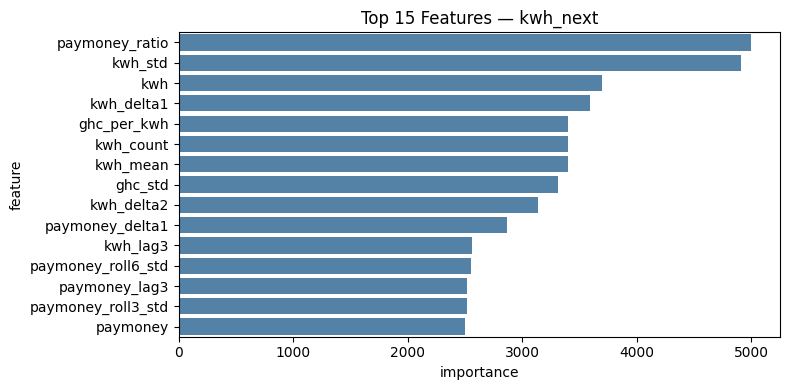

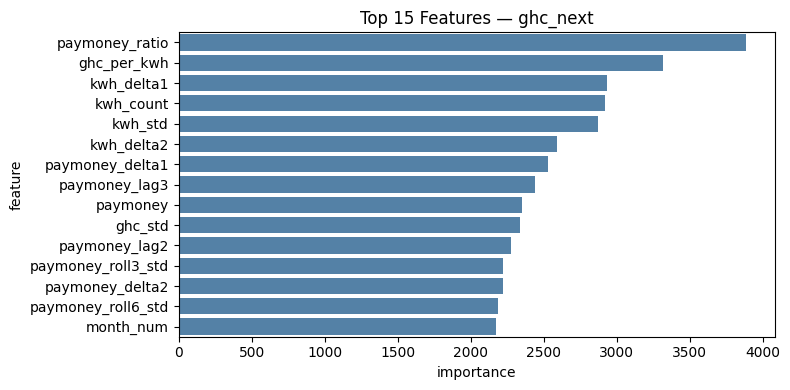

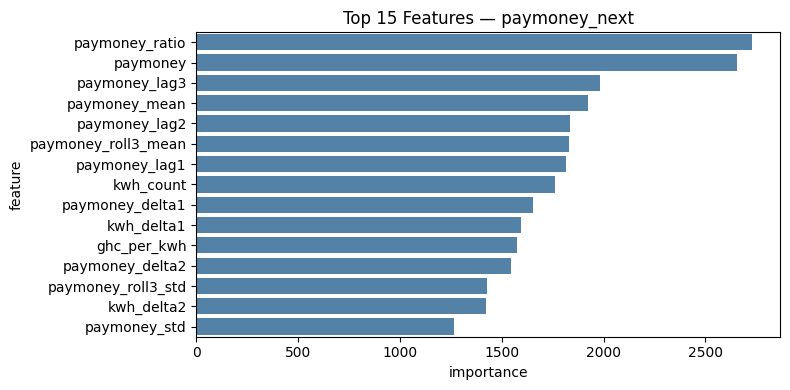

In [28]:
# Cell 24: feature importance plots
import matplotlib.pyplot as plt
import seaborn as sns

for t, model in tuned_models.items():
    imp_df = pd.DataFrame({
        "feature": model.feature_name_,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False).head(15)

    plt.figure(figsize=(8,4))
    sns.barplot(data=imp_df, x="importance", y="feature", color="steelblue")
    plt.title(f"Top 15 Features — {t}")
    plt.tight_layout()
    plt.show()


In [32]:
X_valid.columns

Index(['month_num', 'year', 'month_sin', 'month_cos', 'loc_enc', 'res_enc',
       'kwh', 'ghc', 'paymoney', 'kwh_lag1', 'kwh_lag2', 'kwh_lag3',
       'ghc_lag1', 'ghc_lag2', 'ghc_lag3', 'paymoney_lag1', 'paymoney_lag2',
       'paymoney_lag3', 'kwh_roll3_mean', 'kwh_roll3_std', 'kwh_roll6_mean',
       'kwh_roll6_std', 'ghc_roll3_mean', 'ghc_roll3_std', 'ghc_roll6_mean',
       'ghc_roll6_std', 'paymoney_roll3_mean', 'paymoney_roll3_std',
       'paymoney_roll6_mean', 'paymoney_roll6_std', 'kwh_mean', 'kwh_std',
       'kwh_count', 'ghc_mean', 'ghc_std', 'ghc_count', 'paymoney_mean',
       'paymoney_std', 'paymoney_count', 'kwh_delta1', 'kwh_delta2',
       'ghc_delta1', 'ghc_delta2', 'paymoney_delta1', 'paymoney_delta2',
       'ghc_per_kwh', 'paymoney_ratio'],
      dtype='object')

In [30]:
# Cell 25: create per-meter predictions safely
# ensure meterid column is available
pred_meter = X_valid.copy()

# merge meterid from original df using index
pred_meter = pred_meter.merge(
    df[["meterid"]], left_index=True, right_index=True, how="left"
)

# add predictions
for t in tuned_models:
    pred_meter[f"{t}_pred"] = tuned_models[t].predict(X_valid)
    pred_meter[f"{t}_true"] = y_valid[t].values

# aggregate by meterid
meter_summary = (
    pred_meter.groupby("meterid")[
        [f"{t}_pred" for t in tuned_models] +
        [f"{t}_true" for t in tuned_models]
    ].mean()
)

meter_summary.head(10)


,kwh_next_pred,ghc_next_pred,paymoney_next_pred,kwh_next_true,ghc_next_true,paymoney_next_true
meterid,,,,,,
1,39.890923,32.094086,45.171858,34.950000,27.886625,42.500000
2,297.870141,180.548021,88.702373,309.275000,191.145788,142.042500
3,87.203560,68.831938,20.049362,96.000000,76.598633,20.000000
4,33.028549,25.566948,22.817644,26.140000,20.857160,28.000000
5,114.522005,56.805879,35.577730,118.425000,61.068613,37.500000
6,124.584318,67.069042,49.952200,127.633333,67.092717,54.916667
7,175.955529,96.579962,85.706567,167.075000,92.895488,90.000000
8,154.254601,83.705511,59.572802,136.187500,72.688862,55.036250
9,129.167109,67.967755,56.920354,127.457143,66.977443,62.071429


In [34]:
import sys, os
sys.path.append(os.path.abspath(".."))  # go one level up to include volta/


In [36]:
# Final models trained on all available data (train + valid)
from lightgbm import LGBMRegressor
import joblib, os
import pandas as pd

X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

best_params = {
    "kwh_next":      {"num_leaves":128, "min_child_samples":40, "reg_lambda":1.5},
    "ghc_next":      {"num_leaves":128, "min_child_samples":40, "reg_lambda":1.5},
    "paymoney_next": {"num_leaves":128, "min_child_samples":20, "reg_lambda":2.0},
}

final_models = {}
os.makedirs("../models", exist_ok=True)

for target, params in best_params.items():
    model = LGBMRegressor(
        n_estimators=2500, learning_rate=0.03,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, n_jobs=-1, verbose=-1, **params
    )
    model.fit(X_full, y_full[target])
    path = f"../models/lgbm_final_{target}.pkl"
    joblib.dump(model, path)
    final_models[target] = model
    print("Saved:", path)


Saved: ../models/lgbm_final_kwh_next.pkl
Saved: ../models/lgbm_final_ghc_next.pkl
Saved: ../models/lgbm_final_paymoney_next.pkl


In [37]:
print(0)

0


In [38]:
from volta.services.predictor import predict_next_month
import duckdb

AS_OF = "2020-09-30"
con = duckdb.connect("../data/warehouse.duckdb", read_only=True)
df_raw = con.sql(f"""
    SELECT meterid, chargedate, loc, res, kwh, ghc, paymoney, year
    FROM prod.sales
    WHERE chargedate <= '{AS_OF}'
""").df()

preds = predict_next_month(df_raw, "../models", AS_OF)
print(preds.head(10))


   meterid as_of_month  kwh_next_pred  ghc_next_pred  paymoney_next_pred
0        1  2020-09-09      35.344523      19.798369           40.264069
1        2  2020-09-07     247.323959     129.045783           73.363828
2        3  2020-04-28      95.079576      73.783753           18.803486
3        4  2020-08-12      37.695458      13.063632           25.987625
4        5  2020-09-04     185.955080      83.283682           43.163920
5        6  2020-07-29     171.067829      76.776077           59.178904
6        7  2020-09-04     164.906256      81.982754           70.961816
7        8  2020-09-03     143.303819      66.619531           51.189185
8        9  2020-09-01     162.444980      68.568161           42.260448
9       10  2020-07-20     113.542818      48.942505           33.915755


In [39]:
preds

,meterid,as_of_month,kwh_next_pred,ghc_next_pred,paymoney_next_pred
0,1,2020-09-09,35.344523,19.798369,40.264069
1,2,2020-09-07,247.323959,129.045783,73.363828
2,3,2020-04-28,95.079576,73.783753,18.803486
3,4,2020-08-12,37.695458,13.063632,25.987625
4,5,2020-09-04,185.955080,83.283682,43.163920
...,...,...,...,...,...
68187,69061,2020-09-01,59.325641,24.024172,26.124549
68188,69062,2020-09-05,95.526153,45.483821,33.375385
68189,69063,2020-09-09,198.160844,129.953533,48.646616
68190,69064,2020-09-15,82.846342,40.816114,18.081532
